In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Biblioteques de traitement de texte
import nltk
import string

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

## Fonction

In [2]:
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=3, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

In [3]:
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI,title) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title(title)
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des mots par clusters')
    
    plt.show()
    print("ARI : ", ARI)


In [4]:
def bag_word(df,vectorizer,label):
    cvect = vectorizer(stop_words='english', max_df=0.95, min_df=1)
    cv_fit = cvect.fit(df[label])
    cv_transform = cvect.transform(df[label])  
    
    return cv_transform,cv_fit

In [5]:
def graph_bag_word(df,vectorizer,label,title):
    val,voc=bag_word(df,vectorizer,label)
    print(f"{vectorizer.__name__}: ")
    print("-----------------")
    ARI, X_tsne, labels = ARI_fct(val)
    TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI,title)
    return val,voc

In [6]:
def model_word2vec(df,label,maxlen,title):
    ## Characteristiques du model word2vec
    w2v_size=300
    w2v_window=5
    w2v_min_count=1
    w2v_epochs=100
    maxlen = maxlen # adapt to length of sentences
    sentences = df[label].to_list()
    sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
    
    # Création et entraînement du modèle Word2Vec
    print("Build & train Word2Vec model ...")
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                    vector_size=w2v_size,
                                                    seed=42,
                                                    workers=1)
    #                                                workers=multiprocessing.cpu_count())
    w2v_model.build_vocab(sentences)
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    print("Vocabulary size: %i" % len(w2v_words))
    print("Word2Vec trained")
    
    # Préparation des sentences (tokenization)
    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                         maxlen=maxlen,
                                                         padding='post') 

    num_words = len(tokenizer.word_index) + 1
    print("Number of unique words: %i" % num_words)
    
    # Création de la matrice d'embedding

    print("Create Embedding matrix ...")
    w2v_size = 300
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i=0
    j=0

    for word, idx in word_index.items():
        i +=1
        if word in w2v_words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]

    word_rate = np.round(j/i,4)
    print("Word embedding rate : ", word_rate)
    print("Embedding matrix: %s" % str(embedding_matrix.shape))
    
    # Création du modèle
    input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
    word_input=Input(shape=(maxlen,),dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size,
                             output_dim=w2v_size,
                             weights = [embedding_matrix],
                             input_length=maxlen)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input],word_vec)

    embed_model.summary()
    
    embeddings = embed_model.predict(x_sentences)
    embeddings.shape
    
    ARI, X_tsne, labels = ARI_fct(embeddings)
    
    TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI,title)
    return embeddings

#### Modele BERT

In [7]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot

In [8]:
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

#### model use 

In [9]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [34]:
def model_use(df,label,batchsize,title):
    batch_size = batchsize
    sentences = df['description_product_dl'].to_list()
    features_USE = feature_USE_fct(sentences, batch_size)
    ARI, X_tsne, labels = ARI_fct(features_USE)
    TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI,title)
    return features_USE

In [11]:
def model_bert(df,label,title):
    ## Creation du modele 
    max_length = 64
    batch_size = 10
    model_type = 'bert-base-uncased'
    model = TFAutoModel.from_pretrained(model_type)
    sentences = df[label].to_list()
    ##
    features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')
    ## Score ARI
  
    return features_bert

## Bag of words 

In [12]:
df=pd.read_csv(r"df_text.csv")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   uniq_id                      1050 non-null   object
 1   product_name                 1050 non-null   object
 2   description                  1050 non-null   object
 3   category_1                   1050 non-null   object
 4   description_bow_lem          1050 non-null   object
 5   description_dl               1050 non-null   object
 6   description_product_bow_lem  1050 non-null   object
 7   description_product_dl       1050 non-null   object
dtypes: object(8)
memory usage: 65.8+ KB


In [14]:
l_cat = list(set(df['category_1']))
y_cat_num = [(1-l_cat.index(df.iloc[i]['category_1'])) for i in range(len(df))]

## Modelisation par Frequence des mots 

### Modele Bag of words avec des unigrammes

CountVectorizer: 
-----------------
ARI :  0.3373 time :  21.0


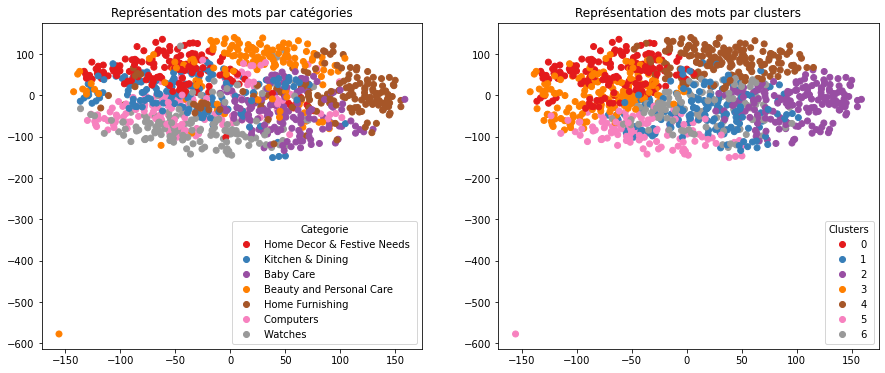

ARI :  0.3373


In [15]:
val_bw_description,voc_bw=graph_bag_word(df,CountVectorizer,'description_bow_lem','Représentation des mots par catégories')

CountVectorizer: 
-----------------
ARI :  0.4358 time :  17.0


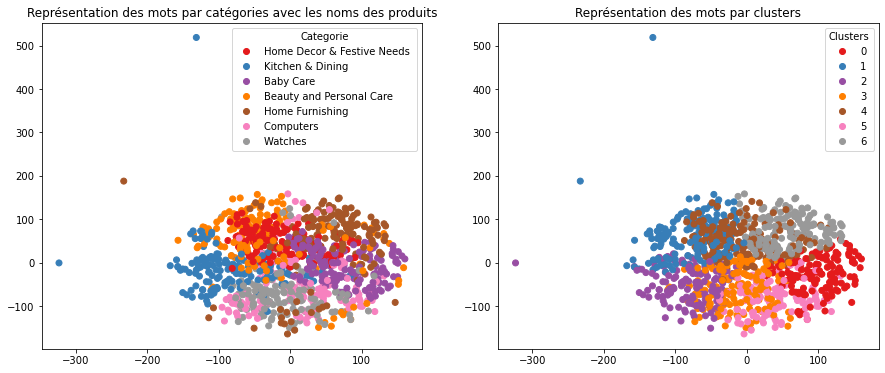

ARI :  0.4358


In [16]:
val_bw_description_product,voc_bw_description_product=graph_bag_word(df,CountVectorizer,'description_product_bow_lem',
                                          'Représentation des mots par catégories avec les noms des produits')

Ci-dessus, on observe 2 modeles de cluster, le premier prend en compte seulement la description, le deuxieme considere le nom du produit plus la description, on remarque qu'avec cette petite variation le score ARI de nos cluster est amelioré, ca veut dire que l'influence de l'aleatoire lors de creation des cluster est diminué. 

### Modele TFIDF

TfidfVectorizer: 
-----------------
ARI :  0.4657 time :  12.0


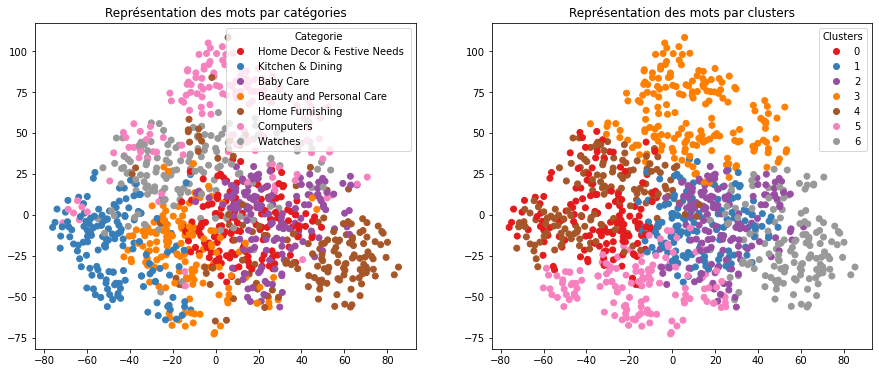

ARI :  0.4657


In [17]:
val_tfid_description,voc_tfid_description=graph_bag_word(df,TfidfVectorizer,
                                                         'description_bow_lem','Représentation des mots par catégories')

TfidfVectorizer: 
-----------------
ARI :  0.4948 time :  14.0


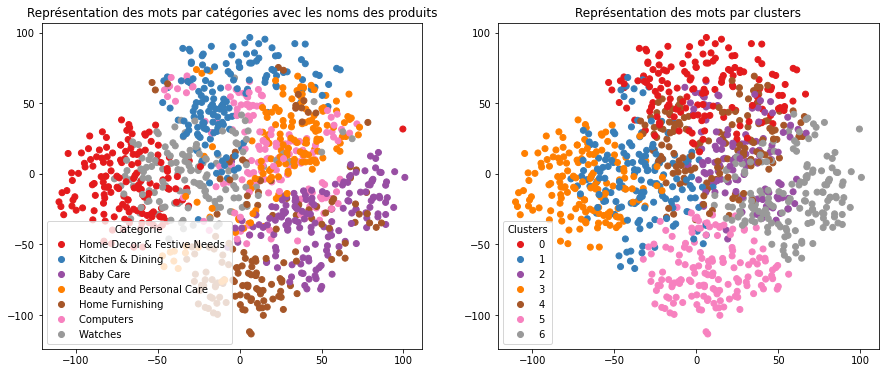

ARI :  0.4948


In [18]:
val_tfid_description_product,voc_tfid_description_product=graph_bag_word(df,TfidfVectorizer,'description_product_bow_lem',
                                            'Représentation des mots par catégories avec les noms des produits')

Ci-dessus,On observe que la distribution de nos cluster n'est pas parfait dans le temps, on testera d'autres methodes afin de choisir le meilleur model pour la creation des cluster a l'aide du traitement de texte

In [19]:
df['length_bow'] = df['description_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", df['length_bow'].max())
df['length_dl'] = df['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df['length_dl'].max())

max length bow :  1137
max length dl :  1913


## Modele Word2Vec

Build & train Word2Vec model ...
Vocabulary size: 4714
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 4715
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4715, 300)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1137)]            0         
                                                                 
 embedding (Embedding)       (None, 1137, 300)         1414500   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,414,500
Trainable params: 1,414,500
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s 1

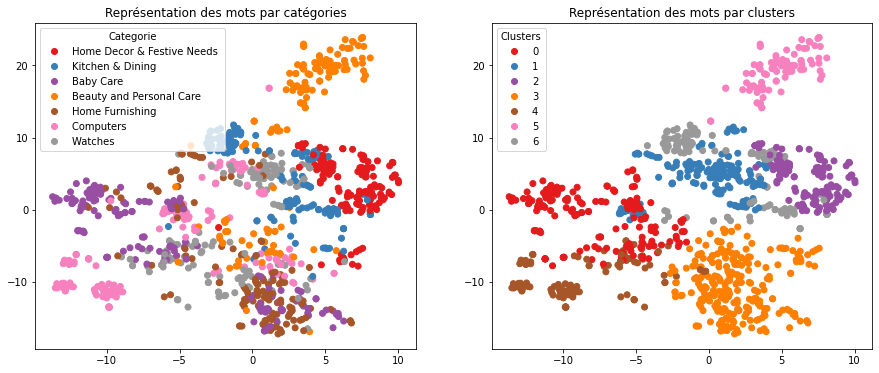

ARI :  0.3808


In [20]:
val_word2vec_description=model_word2vec(df,'description_bow_lem',1137,'Représentation des mots par catégories')

Build & train Word2Vec model ...
Vocabulary size: 4714
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 4715
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4715, 300)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1137)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1137, 300)         1414500   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,414,500
Trainable params: 1,414,500
Non-trainable params: 0
_________________________________________________________________
33/33 [==============================] - 0s

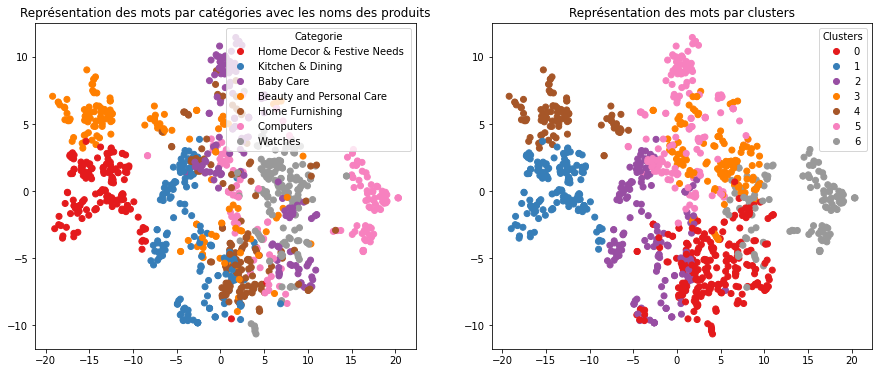

ARI :  0.4545


In [21]:
val_word2vec_description_product=model_word2vec(df,'description_product_bow_lem',1137,'Représentation des mots par catégories avec les noms des produits')

De même que dans les modeles de bag of word, on observe que la representation des cluster s'ameliorere quand on considere les noms des produits, on observe que le score ARI est ameliorer d'au moins 7 points.

### Modele bert

In [22]:
val_bert_description=model_bert(df,'description_dl','title')

loading configuration file config.json from cache at C:\Users\cardn/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\cardn/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb42

1/1 [==============================] - 1s 582ms/step
temps traitement :  71.0


ARI :  0.3331 time :  12.0


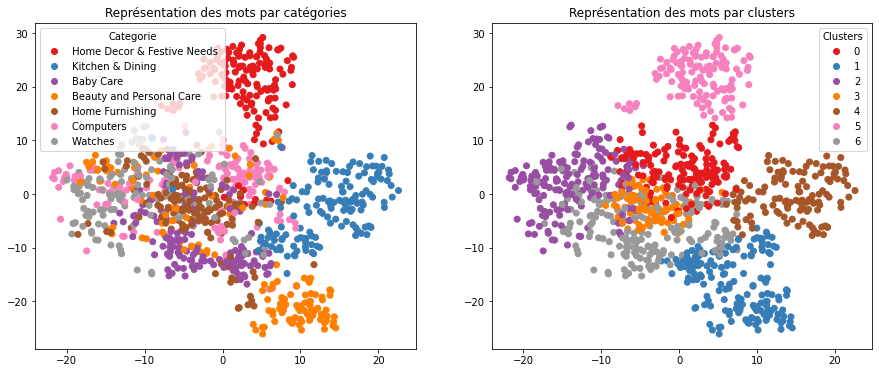

ARI :  0.3331


In [23]:
ARI, X_tsne, labels = ARI_fct(val_bert_description)
    ###
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI,'Représentation des mots par catégories')

In [24]:
val_bert_description_product=model_bert(df,'description_product_dl','title')

loading configuration file config.json from cache at C:\Users\cardn/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\cardn/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb42

1/1 [==============================] - 1s 616ms/step
temps traitement :  70.0


ARI :  0.3996 time :  16.0


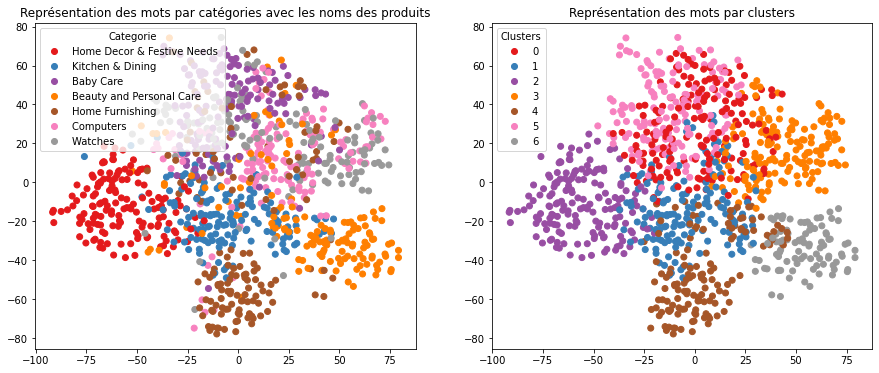

ARI :  0.3996


In [33]:
ARI, X_tsne, labels = ARI_fct(val_bert_description_product)
    ###
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI,'Représentation des mots par catégories avec les noms des produits')

On observe que de tout les model qu'on a testé, le model bert ne convient pas a notre cas, il faudra donc n'est pas le prendre en compte

## Modele USE 

In [26]:
import os
os.environ["TFHUB_CACHE_DIR"] = "some_dir"

In [27]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

ARI :  0.4696 time :  12.0


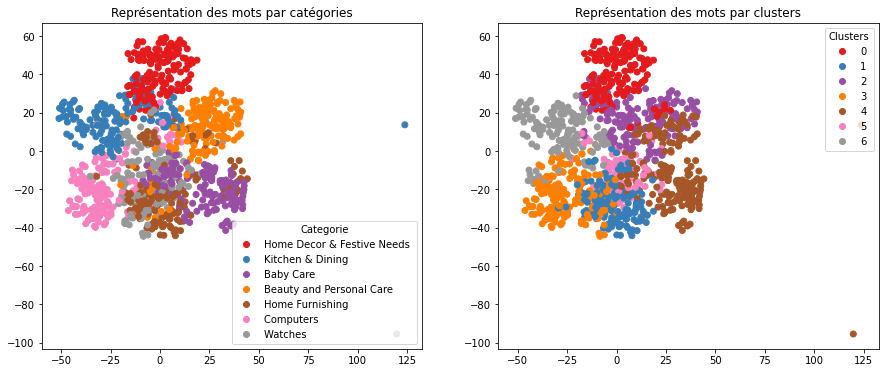

ARI :  0.4696


In [35]:
val_mu_description=model_use(df,'description_dl',10,'Représentation des mots par catégories')

ARI :  0.4696 time :  13.0


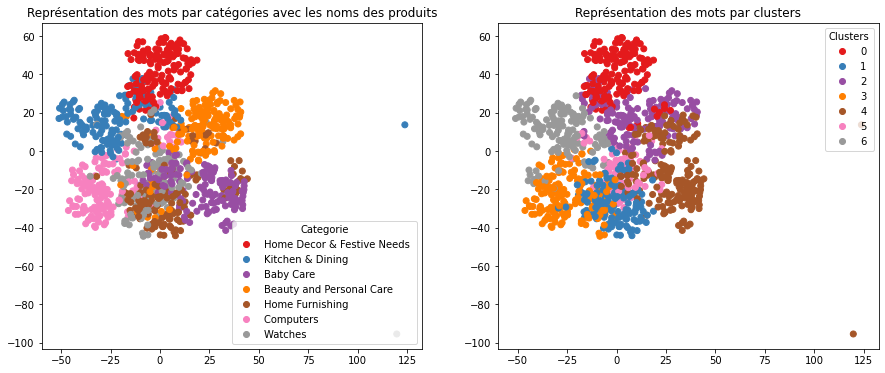

ARI :  0.4696


In [36]:
val_mu_description_product=model_use(df,'description_product_dl',10,'Représentation des mots par catégories avec les noms des produits')

On observe que pour le model Use, ajouter les noms des produit n'as pas d'influence sur la clusterification des nos données, on peut donc negligé les noms des produits si on utilise ce modele

## DF Final

Pour la suite, la representation du modele qui nous apportent le mieux cluster est le tfidf, on considerera donc cette representation 

In [30]:
voc=voc_tfid_description_product.get_feature_names_out()
data = pd.DataFrame(val_tfid_description_product.todense(), columns=voc)
df_text_final=df.join(data,lsuffix='_caller')

In [31]:
df_text_final.head(5)

,uniq_id,product_name,description_caller,category_1,description_bow_lem,description_dl,description_product_bow_lem,description_product_dl,length_bow,length_dl,...,zinc,zingalalaa,zip,zipexterior,zipper,zippered,zone,zoom,zora,zyxel
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,"['key', 'feature', 'elegance', 'polyester', 'm...","['key', 'features', 'of', 'elegance', 'polyest...","['elegance', 'polyester', 'multicolor', 'abstr...","['elegance', 'polyester', 'multicolor', 'abstr...",467,749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,"['specification', 'sathiyas', 'cotton', 'bath'...","['specifications', 'of', 'sathiyas', 'cotton',...","['sathiyas', 'cotton', 'bath', 'towel', 'speci...","['sathiyas', 'cotton', 'bath', 'towel', 'speci...",190,258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,"['key', 'feature', 'eurospa', 'cotton', 'terry...","['key', 'features', 'of', 'eurospa', 'cotton',...","['eurospa', 'cotton', 'terry', 'face', 'towel'...","['eurospa', 'cotton', 'terry', 'face', 'towel'...",473,779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,"['key', 'feature', 'santosh', 'royal', 'fashio...","['key', 'features', 'of', 'santosh', 'royal', ...","['santosh', 'royal', 'fashion', 'cotton', 'pri...","['santosh', 'royal', 'fashion', 'cotton', 'pri...",343,448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,"['key', 'feature', 'jaipur', 'print', 'cotton'...","['key', 'features', 'of', 'jaipur', 'print', '...","['jaipur', 'print', 'cotton', 'floral', 'king'...","['jaipur', 'print', 'cotton', 'floral', 'king'...",468,694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_text_final.to_csv('df_text_final.csv', index=False)